# **Financial Fraud Detection**

### Fraud detection in financial services, particularly in mobile money, faces a major challenge: the privacy of financial transactions. Researchers often struggle to access detailed data due to privacy concerns. To bridge this gap, the PaySim simulator was developed. It creates synthetic datasets that mirror real-world mobile money transactions by using aggregated data from private sources. Essentially, it simulates normal user behavior and adds fraudulent activities, enabling researchers to test their fraud detection methods without exposing sensitive information.

###  PaySim is based on real transaction data from a mobile money service in an African country. This data was provided by a multinational company that operates in over 14 countries. By creating synthetic yet realistic datasets, PaySim serves as a crucial tool for advancing fraud detection research.






#### Here’s a breakdown of the key elements in the PaySim dataset:


**step:** Represents a unit of time equal to one hour in the real world. The simulation runs for a total of 744 steps, which corresponds to a 30-day period.

**type:** Indicates the kind of transaction. The available types include CASH-IN, CASH-OUT, DEBIT, PAYMENT, and TRANSFER.

**amount:** The value of the transaction, recorded in the local currency.

**nameOrig:**  Identifies the customer who initiated the transaction.

**oldbalanceOrg:** The customer's balance before the transaction occurred.

**newbalanceOrig:** The customer's balance after the transaction.

**nameDest:** Identifies the recipient of the transaction.

**oldbalanceDest:** The initial balance of the recipient before the transaction. There is no information for customers whose names start with "M" (indicating merchants).

**newbalanceDest:** The new balance of the recipient after the transaction. As with "oldbalanceDest," there is no information for customers whose names start with "M."

**isFraud:**  Indicates whether a transaction is classified as fraudulent. In this dataset, fraudulent behavior typically involves taking control of a customer’s account, attempting to transfer funds to another account, and then cashing out.

**isFlaggedFraud:** Flags transactions that cross a certain threshold. In this dataset, any transfer exceeding 200,000 in a single transaction is flagged as potentially fraudulent.

##### These fields provide a comprehensive view of transaction activities, helping researchers simulate and study real-world scenarios. By using PaySim, researchers can explore and test fraud detection techniques safely, without compromising actual financial data.

#**Importing Libraries**


In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


#**Loading Data**

In [4]:
# Step 1: Load data
df = pd.read_csv('FinancialData.csv') 

#**Data Exploration**

In [5]:
# Display the first 10 rows of the DataFrame
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [6]:
# To know the size of datast
df.shape

(6362620, 11)

The dataset has 6,362,620 rows and 11 columns.

In [7]:
# Get an overview of the DataFrame including data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


The DataFrame has 6,362,620 entries with 11 columns, comprising 5 of type `float64`, 3 of type `int64`, and 3 of type `object`, requiring over 534 MB of memory.

In [8]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


The `df.describe()` method provides a summary of statistical metrics for the DataFrame's numerical columns, such as count, mean, standard deviation, minimum, maximum, and quartiles, offering a quick overview of the dataset's distribution and characteristics.

#**EDA**


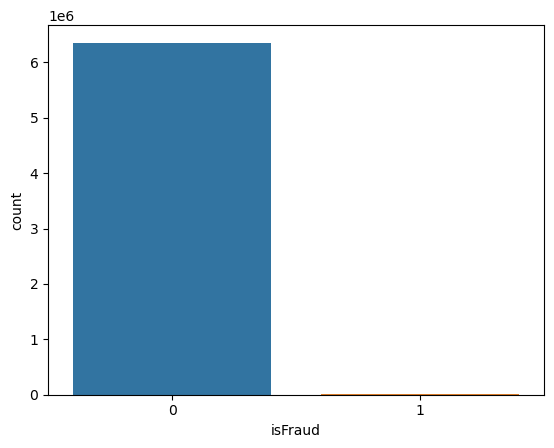

In [9]:
sns.countplot(x='isFraud', data=df)
plt.show()

The count plot from the visualization shows the distribution of fraud (where
`isFraud` is 1) versus non-fraudulent transactions (where `isFraud` is 0).

*   The plot indicates a significant imbalance, with far more non-fraudulent transactions compared to fraudulent ones.
*   This imbalance can present challenges for fraud detection models, requiring techniques to address skewed data.



In [10]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [11]:
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [12]:
# percentage of fraud happend.
per= (8213/6362620)*100
per

0.12908204481801522




*   The data shows that out of 6,362,620 transactions, 6,354,407 are non-fraudulent while 8,213 are fraudulent. This results in a fraud percentage of approximately 0.13%, indicating a low incidence of fraudulent activity in the dataset.


---


*   
The high disparity between non-fraudulent and fraudulent transactions reflects
the challenge of detecting fraud due to the rarity of such cases, which requires specialized techniques to identify these anomalies within a vast amount of regular transactions.

In [13]:
# checking if the recipient account of a fraudulent transfer was used as a sending account for cashing out
fraud = df[df["isFraud"] == 1]
valid = df[df["isFraud"] == 0]

In [14]:
fraud_transfer = fraud[fraud["type"] == "TRANSFER"]
fraud_cashout = fraud[fraud["type"] == "CASH_OUT"]

fraud_transfer.nameDest.isin(fraud_cashout.nameOrig).any()

False

In [15]:
# adding feature type1
df_new = df.copy() # creating copy of dataset in case I need original dataset
df_new["Type2"] = np.nan # initializing feature column

# filling feature column
df_new.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('C'),"Type2"] = "CC"
df_new.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('M'),"Type2"] = "CM"
df_new.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('C'),"Type2"] = "MC"
df_new.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('M'),"Type2"] = "MM"

Text(0.5, 1.0, 'oldbalanceDest vs Fraud')

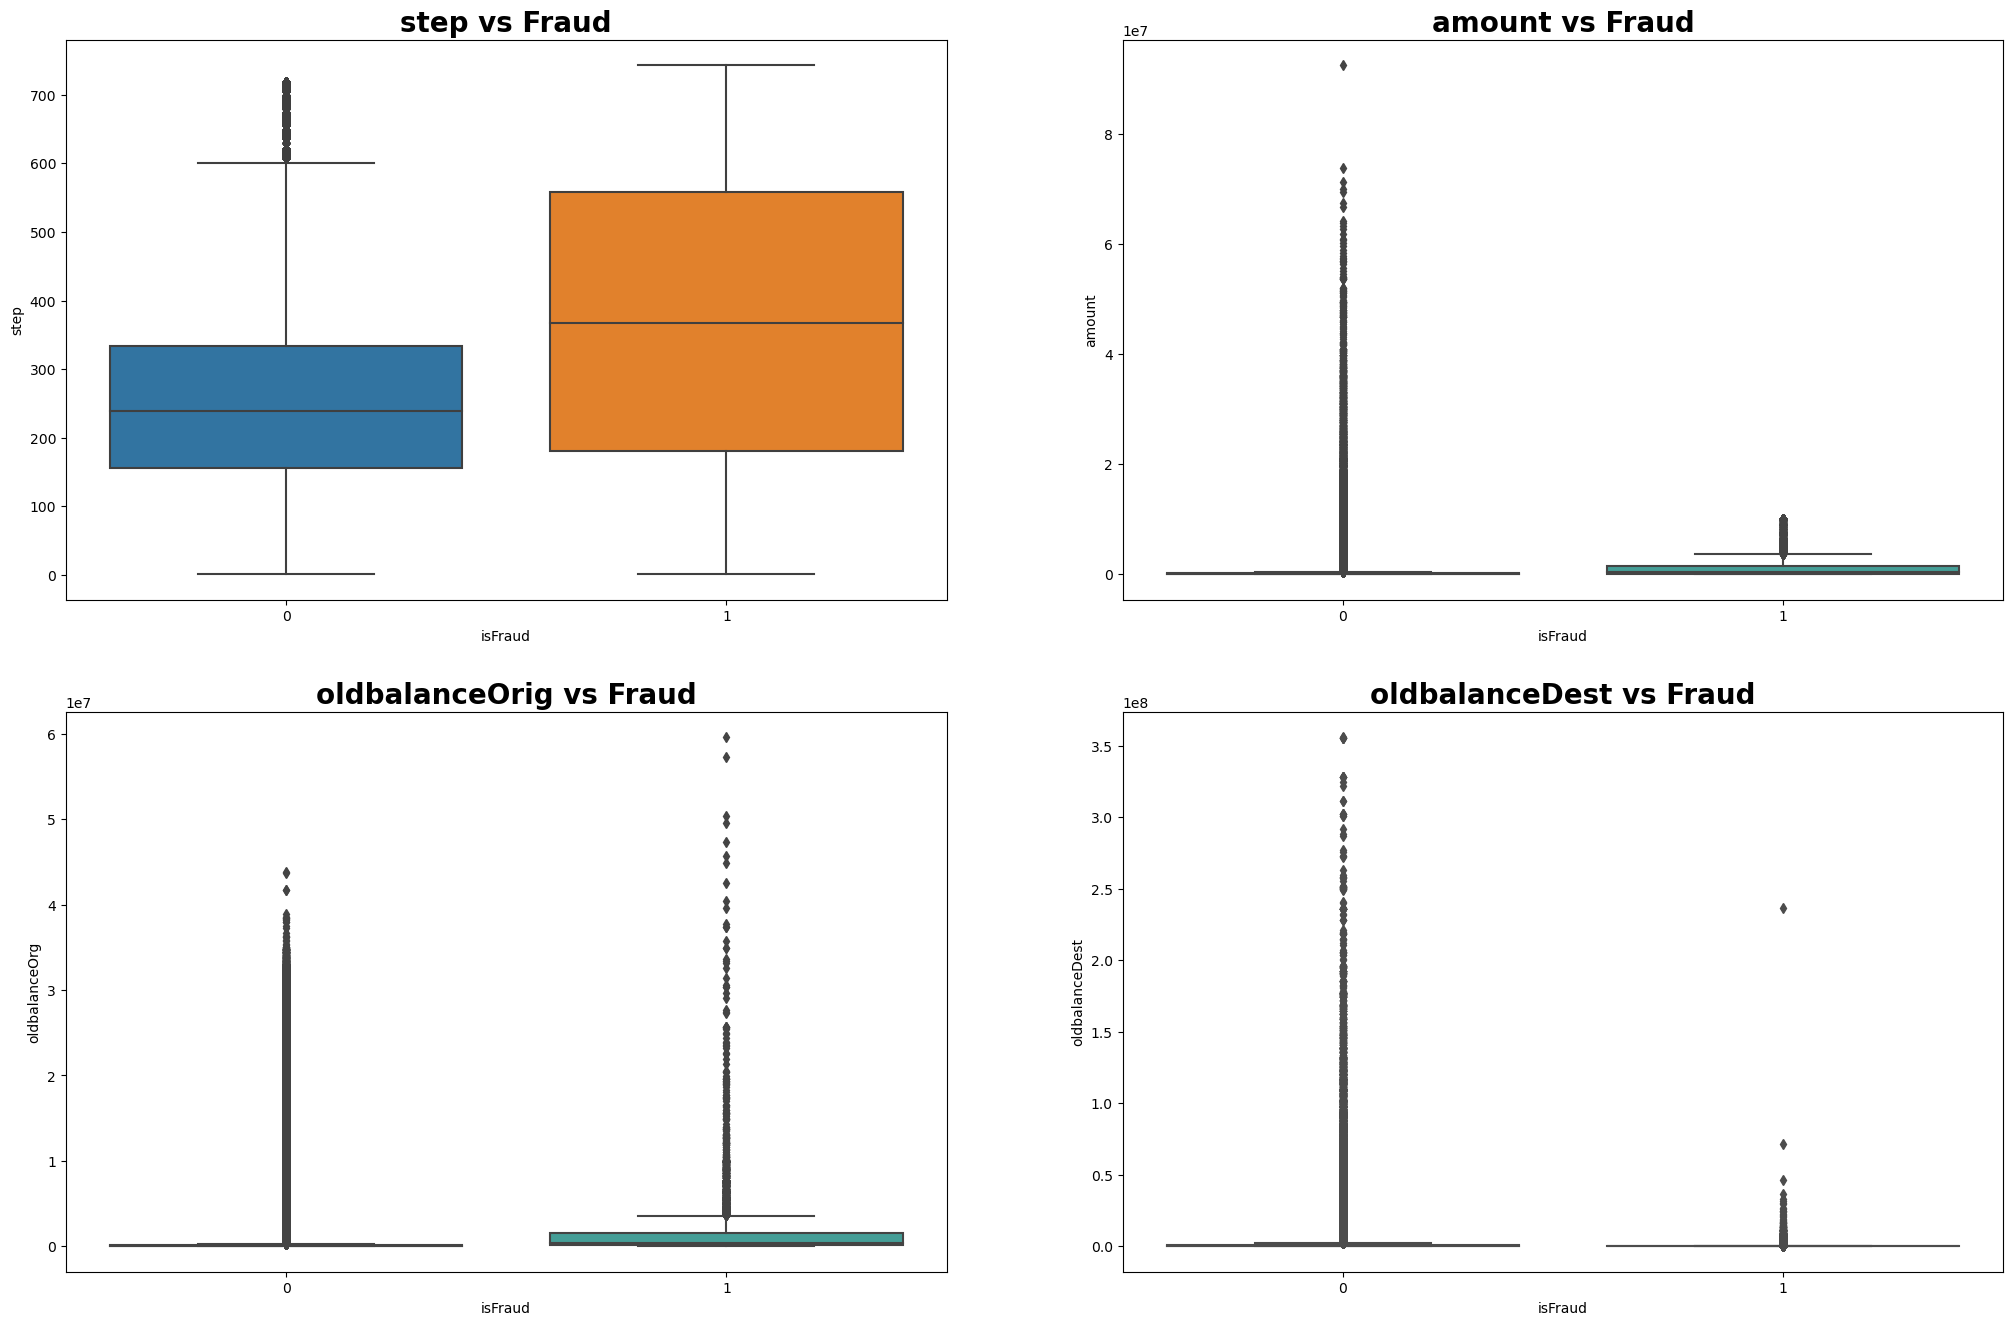

In [16]:
plt.figure(figsize=(25, 16))
plt.subplot(2,2,1)
sns.boxplot(x = 'isFraud', y = 'step', data = df_new)
plt.title('step vs Fraud',fontweight="bold", size=20)
plt.subplot(2,2,2)
sns.boxplot(x = 'isFraud', y = 'amount', data = df_new,palette="husl")
plt.title('amount vs Fraud',fontweight="bold", size=20)
plt.subplot(2,2,3)
sns.boxplot(x = 'isFraud', y = 'oldbalanceOrg', data = df_new, palette= 'husl')
plt.title('oldbalanceOrig vs Fraud',fontweight="bold", size=20)
plt.subplot(2,2,4)
sns.boxplot(x = 'isFraud', y = 'oldbalanceDest', data = df_new,palette="bright")
plt.title('oldbalanceDest vs Fraud',fontweight="bold", size=20)

The boxplot visualization has four panels, each examining a different feature's distribution with respect to fraud.

- The first panel shows `step` vs. `isFraud`, indicating higher dispersion in fraudulent transactions.
- The second panel plots `amount` vs. `isFraud`, with notable outliers among non-fraudulent transactions.
- The third panel visualizes `oldbalanceOrg` vs. `isFraud`, revealing many high outliers in non-fraudulent cases.
- The fourth panel, depicting `oldbalanceDest` vs. `isFraud`, also shows more variability and extreme outliers among non-fraudulent transactions.

These boxplots help identify discrepancies in data distributions between fraudulent and non-fraudulent transactions, which can guide further analysis and model development.

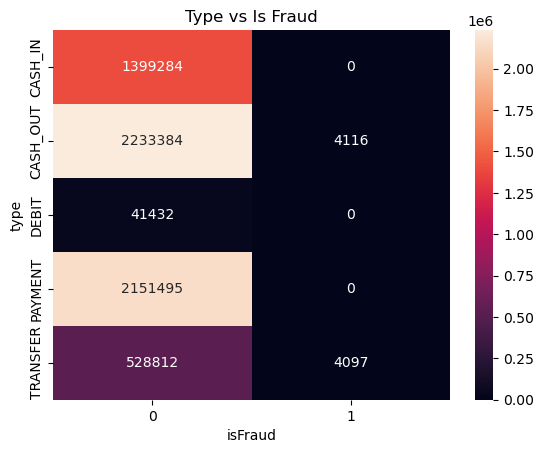

In [17]:
# 2-D Categorical Distributions
# Example for 'type' vs 'isFraud'
plt.figure()
ct = pd.crosstab(df['type'], df['isFraud'])
sns.heatmap(ct, annot=True, fmt='d')
plt.title('Type vs Is Fraud')
plt.show()


*   This indicate that fraudulent transactions mainly occur in CASH-OUT and TRANSFER types, suggesting that fraud detection strategies should prioritize monitoring these high-risk categories.

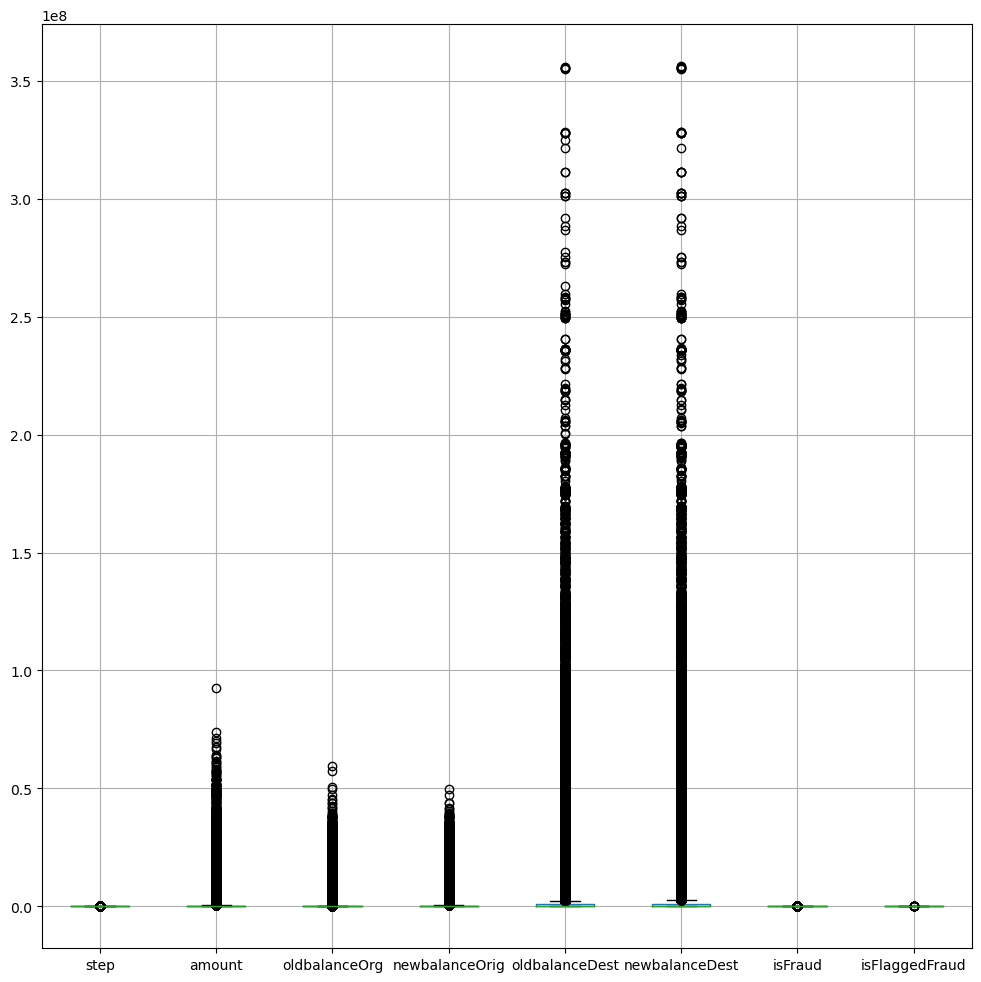

In [18]:
# Box plots for outliers and spread
df.boxplot(figsize=(12, 12))
plt.show()



- The plot shows that `oldbalanceDest` has the widest spread and the most extreme outliers, indicating significant variability in the ending balance of the destination account.
- `amount`, `oldbalanceOrg`, and `newbalanceOrig` exhibit moderate spreads with some outliers, suggesting a range of transaction amounts and account balances before and after transactions.
- `step`, `isFraud`, and `isFlaggedFraud` show little to no variation, indicating these features are relatively consistent across the dataset.

The outliers and spread in these features can inform further analysis to understand the distribution and behavior of transactions, especially for fraud detection.

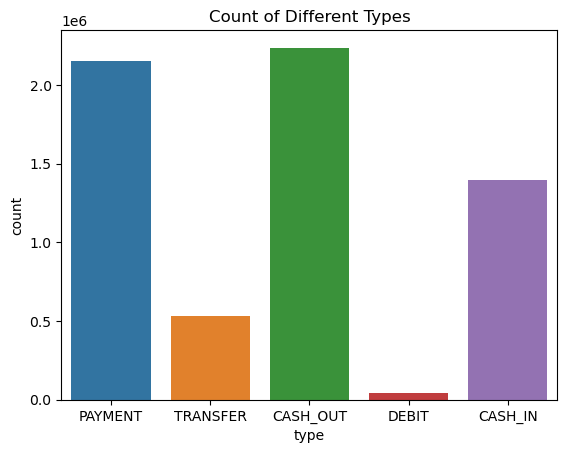

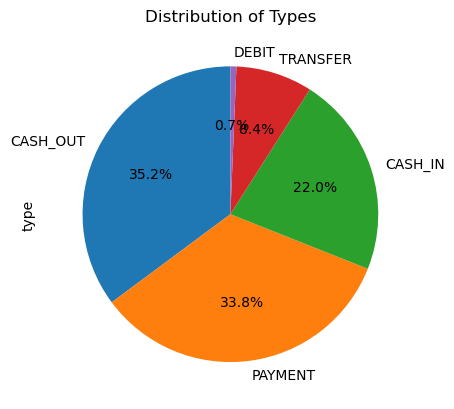

In [19]:
# Count plot for categorical distribution
sns.countplot(x='type', data=df)
plt.title('Count of Different Types')
plt.show()

# Pie chart for categorical distribution
df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Types')
plt.show()


The two visualizations depict the distribution of transaction types in a dataset.

- **Count Plot**: This bar chart illustrates the frequency of each transaction type. CASH-OUT and PAYMENT are the most common, with around 2 million occurrences each. CASH-IN is less frequent, followed by TRANSFER. DEBIT is the least common, showing minimal activity.

- **Pie Chart**: This pie chart represents the percentage distribution of transaction types. CASH-OUT has the highest proportion at 35.2%, with PAYMENT close behind at 33.8%. CASH-IN represents 22.0%, while TRANSFER is 8.4%. DEBIT is the smallest slice, comprising just 0.7% of transactions.

These plots give a comprehensive overview of transaction distribution, revealing the relative prominence of each type and helping identify potential areas for further analysis, such as identifying trends or spotting anomalies related to fraud detection.

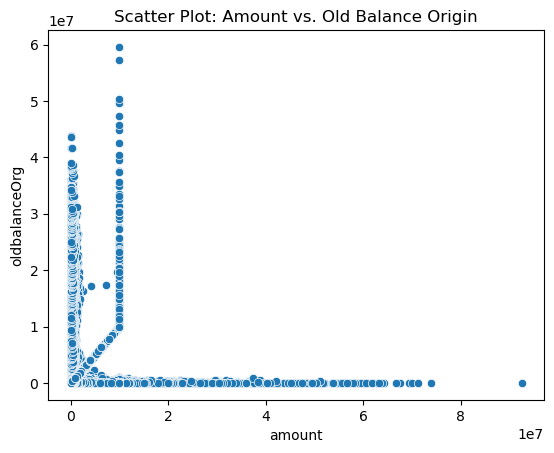

In [20]:
sns.scatterplot(x='amount', y='oldbalanceOrg', data=df)
plt.title('Scatter Plot: Amount vs. Old Balance Origin')
plt.show()

The scatter plot "Amount vs. Old Balance Origin" displays the relationship between transaction amounts and the originating account's balance.

- Most data points are clustered near the origin, indicating that many transactions involve relatively small amounts and originate from accounts with low balances.
- There are some outliers with large amounts and high originating balances, suggesting a smaller subset of transactions with high value.
- The vertical alignment of points along low amounts and the horizontal clustering along low balances indicate skewed distributions, which could impact data analysis or model training.

.

##**Pre-processing**



In [21]:
# Step 3: Pre-processing

# checking missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

The dataset has no missing values, so there's no need for data imputation or removal due to null entries.

In [22]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [23]:
# Encode categorical variables
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

**Label encoding** converts categorical variables into numerical representations, facilitating their use in machine learning algorithms that require numerical input for processing.

In [24]:
a=df.drop(['nameOrig','nameDest'],axis=1)

In [25]:
b=a.corr()

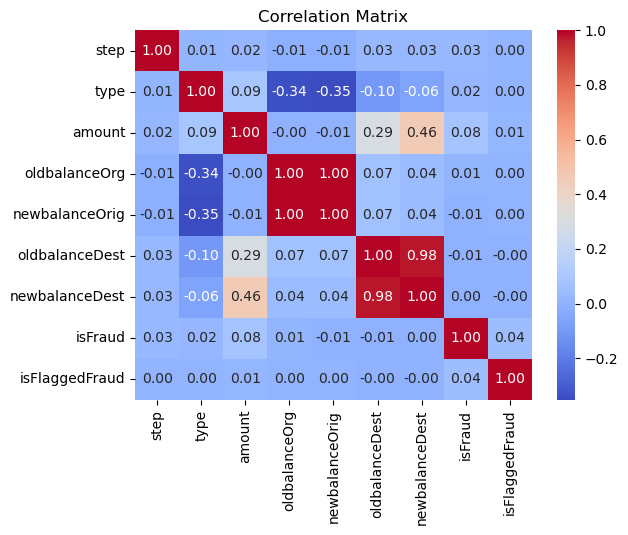

In [26]:
sns.heatmap(b, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [27]:
#  Sampling
# Using sampling technique due to computing power
sample_df = df.sample(frac=0.4, random_state=42)

- We are sampling a fraction (40% in this case) of the dataframe to reduce computational burden

In [28]:
sample_df.shape

(2545048, 11)

In [29]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

#**Spliting Data**

In [30]:
# Step 5: Split data into features and target
X = sample_df.drop(['isFraud', 'isFlaggedFraud','nameDest','nameOrig'], axis=1)
y = sample_df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Dropping unnecessary columns and separating features (X) from target variabl(y),
then splitting the data into training and testing sets

In [31]:
X_train.shape

(2036038, 7)

In [32]:
X_test.shape

(509010, 7)

In [33]:
y_train.shape

(2036038,)

In [34]:
y_test.shape

(509010,)

#**Scaling down the feature**

In [35]:
# Step 6: Standardizing Data with `StandardScaler` for Optimal Model Performance
from sklearn.preprocessing import StandardScaler

In [36]:
sc = StandardScaler()

In [37]:
model=sc.fit(X)

In [38]:
X= model.transform(X)

In [39]:
X

array([[ 0.24284338, -1.26956348,  0.24368031, ..., -0.17225632,
        -0.19156582, -0.30082172],
       [-1.60463293,  0.95252629, -0.27428166, ..., -0.28584117,
        -0.32475559, -0.33406571],
       [-1.63975606, -1.26956348, -0.04565367, ..., -0.20377642,
        -0.26549312, -0.32072504],
       ...,
       [-0.38937285,  0.95252629, -0.28040782, ..., -0.21803714,
        -0.32475559, -0.33406571],
       [ 0.41143437, -0.52886689,  0.18071887, ..., -0.29223975,
        -0.1843709 , -0.12504036],
       [ 1.90065482, -1.26956348, -0.1171341 , ...,  1.44409428,
        -0.01560982, -0.0778534 ]])

- The `StandardScaler` standardizes feature by removing the mean and scaling to unit variance, ensuring that each feature contributes equally in models that rely on Euclidean distances or dot products.

#**Model Training and Hyperparameter Tuning**

**1 - Logistic Regression**

In [ ]:
# Step 7: Enhancing Model Accuracy through Training and Hyperparameter Tuning


log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

**2 - Decision Tree**

In [41]:
dt = DecisionTreeClassifier()
dt_grid = {'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10]}
dt_clf = GridSearchCV(dt, dt_grid, cv=3)
dt_clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_split': [2, 5, 10]})

**3 - Random Forest**

In [42]:
rf = RandomForestClassifier()
rf_grid = {'n_estimators': [1, 3], 'max_depth': [10, 20], 'min_samples_leaf': [1, 2]}
rf_clf = GridSearchCV(rf, rf_grid, cv=3)
rf_clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [1, 2],
                         'n_estimators': [1, 3]})

# **Model Evaluation**

- **Assessing model performance with Evaluation Metrics**

In [43]:
# Step 7 Evalution
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

# Function to evaluate a model and include AUC
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)  # Predicted class labels
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Calculate and print AUC score
    auc = roc_auc_score(y_test, y_pred_proba)
    print("AUC Score:", auc)




#Evaluate each model and print results:-

In [44]:
# For Logitic Regression

print("Logistic Regression Results:")
evaluate_model(log_reg, X_test, y_test)



Logistic Regression Results:
Confusion Matrix:
[[507827    493]
 [   409    281]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    508320
           1       0.36      0.41      0.38       690

    accuracy                           1.00    509010
   macro avg       0.68      0.70      0.69    509010
weighted avg       1.00      1.00      1.00    509010

Accuracy: 0.9982279326535825
AUC Score: 0.8555419187046389


In [45]:
# For Decision Tree

print("Decision Tree Results:")
evaluate_model(dt_clf, X_test, y_test)



Decision Tree Results:
Confusion Matrix:
[[508278     42]
 [   118    572]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    508320
           1       0.93      0.83      0.88       690

    accuracy                           1.00    509010
   macro avg       0.97      0.91      0.94    509010
weighted avg       1.00      1.00      1.00    509010

Accuracy: 0.9996856643287951
AUC Score: 0.9631404487302304


In [46]:
# For Random Forest

print("Random Forest Results:")
evaluate_model(rf_clf, X_test, y_test)

Random Forest Results:
Confusion Matrix:
[[508282     38]
 [   149    541]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    508320
           1       0.93      0.78      0.85       690

    accuracy                           1.00    509010
   macro avg       0.97      0.89      0.93    509010
weighted avg       1.00      1.00      1.00    509010

Accuracy: 0.9996326201842793
AUC Score: 0.97749760079238


**4 - Artificial Neural Networks (ANNs)**

- **Artificial Neural Networks** are ideal for large datasets due to their capacity for handling complex relationships and scaling with data volume.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
# Building ANN model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])



In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
# using Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,  # Number of epochs with no improvement after which training will stop
    verbose=1,  # Output messages
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)



In [ ]:
# Training ANN model with early stopping
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=256,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],  # Add the early stopping callback
    verbose=2
)

In [ ]:


# Evaluating the model
_, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy*100:.2f}%")


In [ ]:

# Plotting training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

The images you've uploaded show the results of different machine learning models applied to what seems to be a binary classification task, possibly to predict fraudulent transactions as indicated by the context from a previous conversation. The models and their corresponding performance metrics are as follows:

1. Logistic Regression:
   - The code snippet indicates that a Logistic Regression model was trained with a maximum of 1000 iterations.

2. Random Forest:
   - Confusion Matrix: 508297 true negatives (TN), 23 false positives (FP), 156 false negatives (FN), and 534 true positives (TP).
   - Precision for class 1 (positive class, likely to be fraud): 0.96.
   - Recall for class 1: 0.77.
   - F1-Score for class 1: 0.86.
   - Overall Accuracy: Approximately 99.96%.
   - AUC Score: Approximately 0.98.

3. Decision Tree:
   - Confusion Matrix: 508279 TN, 41 FP, 119 FN, and 571 TP.
   - Precision for class 1: 0.93.
   - Recall for class 1: 0.83.
   - F1-Score for class 1: 0.88.
   - Overall Accuracy: Approximately 99.97%.
   - AUC Score: Approximately 0.96.

4. Neural Network (Epoch Training Log):
   - The training log shows that early stopping was triggered to prevent overfitting.
   - Test Accuracy: 99.86%.

When choosing a model for a dataset that is large and imbalanced, several factors need to be considered:

- **Precision and Recall**: In the context of fraud detection, recall may often be more important than precision as it is crucial to identify as many fraudulent transactions as possible (i.e., a higher recall for class 1 means fewer fraudulent transactions go undetected).

- **Computational Efficiency**: Larger datasets require models that can train efficiently at scale. Neural networks typically require more computational resources and time to train than simpler models like decision trees or logistic regression.

- **Interpretability**: Simple models like decision trees and logistic regression are more interpretable than complex models like neural networks. This can be important for regulatory reasons and for understanding model decisions.

- **AUC Score**: A higher AUC score indicates a better performance of the model in distinguishing between the positive and negative class across all thresholds.

Considering the metrics, the Decision Tree has a slightly better recall for the positive class (0.83 vs. 0.77 for the Random Forest) and a higher AUC score (0.96 vs. 0.98 for the Random Forest), suggesting it is better at identifying positive cases (fraudulent transactions). However, the difference in AUC scores is quite marginal, and the Random Forest has a slightly higher precision.

The Neural Network has a slightly lower test accuracy compared to the other two models, but early stopping may have prevented it from achieving its full potential.

**Conclusion**: Given the high imbalance and large size of the dataset, if the focus is on catching as many fraudulent cases as possible, the Decision Tree might be the preferable model due to its higher recall for the positive class and better balance between precision and recall. However, if computational resources and time are constraints, the Random Forest also offers a good balance with a slightly higher precision and very competitive metrics overall.

